In [1]:
# nltk.download('stopwords')

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [3]:
# Gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, Phrases
from gensim.models.phrases import Phraser
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [4]:
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from nltk.corpus import stopwords
from nltk import Tree

stop_words = stopwords.words('english')

In [6]:
df = pd.read_csv("metadata_final_results.csv")

In [7]:
data = df['Metadata'].dropna().tolist()

In [8]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_60418/1419459543.py:2: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_60418/1419459543.py:5: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [10]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def remove_stopwords_mult(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
bigram = Phrases(data_words, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

data_words_nostops_2 = remove_stopwords_mult(data_words)
data_with_phrases = [trigram_mod[bigram_mod[doc]] for doc in data_words_nostops_2]
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_with_phrases, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_with_phrases)
id2word.filter_extremes(no_below=20, no_above=0.5) # brings down unique tokens from 80 thousand to 12

# Create Corpus
texts = data_with_phrases

# Term Frequency list   
corpus = [id2word.doc2bow(text) for text in texts] 

In [13]:
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [14]:
# Build LDA model

# increased chunk size to speed up development
# LdaMulticoreModel had slower training time, would have otherwise used it 

lda_model = LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=5, 
                random_state=100,
                update_every=1,
                chunksize=2000,
                passes=10,
                alpha='auto',
                eta='auto',
                per_word_topics=True)

In [15]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2614
Number of documents: 20460


In [16]:
# Check the type of the numbers in the LDA topics
for topic in lda_model.print_topics():
    for word, prob in lda_model.show_topic(topic[0]):
        if isinstance(prob, complex):
            print(f"Complex number found in topic {topic[0]} for word '{word}'")

In [17]:
# Print the Keyword
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.011*"country" + 0.009*"conflict" + 0.009*"un" + 0.009*"violence" + 0.009*"moment" + 0.009*"state" + 0.008*"war" + 0.008*"crisis" + 0.008*"security" + 0.007*"south"'), (1, '0.064*"de" + 0.046*"wikipedia" + 0.034*"war" + 0.028*"ukraine" + 0.027*"la" + 0.021*"en" + 0.019*"russian" + 0.016*"russia" + 0.012*"azerbaijan" + 0.012*"mexico"'), (2, '0.112*"news" + 0.027*"bbc" + 0.026*"latest" + 0.021*"syria" + 0.019*"nytimes_com" + 0.016*"turkish" + 0.016*"world" + 0.015*"iraq" + 0.015*"iran" + 0.013*"turkey"'), (3, '0.139*"rights" + 0.135*"human" + 0.062*"report" + 0.050*"watch" + 0.042*"world" + 0.016*"refworld" + 0.015*"international" + 0.014*"countries" + 0.013*"information" + 0.012*"network"'), (4, '0.040*"killed" + 0.020*"soldiers" + 0.017*"military" + 0.016*"attack" + 0.015*"forces" + 0.014*"said" + 0.014*"two" + 0.013*"people" + 0.009*"least" + 0.009*"army"')]


In [18]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [19]:
try:
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
except Exception as e:
    print(f"Error preparing LDA visualization: {e}")

In [20]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.032748  0.042499       1        1  34.988431
4     -0.192817  0.139826       2        1  34.231415
2     -0.060132  0.183375       3        1  12.064864
1     -0.104790 -0.367836       4        1   9.851755
3      0.390487  0.002136       5        1   8.863535, topic_info=                      Term         Freq        Total Category  logprob  \
343                 rights  3686.000000  3686.000000  Default  30.0000   
17                    news  4570.000000  4570.000000  Default  29.0000   
328                  human  3444.000000  3444.000000  Default  28.0000   
700                     de  1786.000000  1786.000000  Default  27.0000   
160                 report  1956.000000  1956.000000  Default  26.0000   
..                     ...          ...          ...      ...      ...   
278              countries   344.674805   601.170946   Topic5  -4.2811   
181  amnesty_international   262.025131   415.583518   Topic5  -4.5552   
132          international   381.424153   953.189329   Topic5  -4.1798   
293               regional   246.054174   389.953936   Topic5  -4.6181   
446                freedom   201.543018   278.954655   Topic5  -4.8177   

     loglift  
343  30.0000  
17   29.0000  
328  28.0000  
700  27.0000  
160  26.0000  
..       ...  
278   1.8669  
181   1.9620  
132   1.5073  
293   1.9627  
446   2.0982  

[271 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
415       1  0.995046       abuses
1212      3  0.995227      accused
1374      1  0.993382       action
29        2  0.979059  afghanistan
29        5  0.018047  afghanistan
...     ...       ...          ...
215       3  0.004606         year
86        1  0.865585        years
86        2  0.113078        years
86        3  0.020192        years
2514      2  0.998037        yemen

[358 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

In [21]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -6.987081304363798


In [22]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_with_phrases, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5142632856178068


## Find optimzed number of topics

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=num_topics, 
                    random_state=100,
                    update_every=1,
                    chunksize=2000,
                    passes=10,
                    alpha='auto',
                    eta='auto',
                    per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_with_phrases, start=5, limit=30, step=5)

5
10
15
20
25


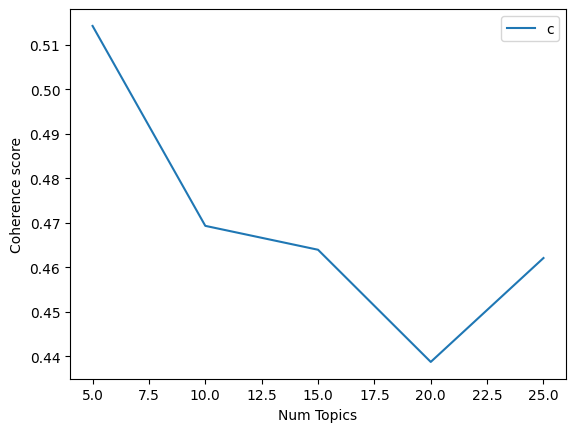

In [25]:
limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
optimal_model = lda_model

In [27]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.5143
Num Topics = 10  has Coherence Value of 0.4693
Num Topics = 15  has Coherence Value of 0.464
Num Topics = 20  has Coherence Value of 0.4388
Num Topics = 25  has Coherence Value of 0.4621


In [28]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
    top_list = []

    # Get main topic in each document
    for i, row in enumerate(list(ldamodel[corpus])):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Percent Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                top_list.append([int(topic_num), round(prop_topic,4), topic_keywords])
            else:
                break
    sent_topics_df = pd.DataFrame(top_list, columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
    
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [29]:
original_df = pd.read_csv("../aed.csv")

In [30]:
original_df

id  year                   country  iso       region  \
0     AFG 1989  1989               Afghanistan  AFG         Asia   
1     ANG 1989  1989                    Angola  ANG       Africa   
2     BNG 1989  1989                Bangladesh  BNG         Asia   
3     CAM 1989  1989      Cambodia (Kampuchea)  CAM         Asia   
4     CHA 1989  1989                      Chad  CHA       Africa   
...        ...   ...                       ...  ...          ...   
1902  UKR 2022  2022                   Ukraine  UKR       Europe   
1903  UAE 2022  2022      United Arab Emirates  UAE  Middle East   
1904  USA 2022  2022  United States of America  USA     Americas   
1905  VEN 2022  2022                 Venezuela  VEN     Americas   
1906  YAR 2022  2022       Yemen (North Yemen)  YAR  Middle East   

     Dominant_Topic  deaths_a  deaths_b  deaths_civilians  deaths_unknown  \
0               1.0       226       839               303            4043   
1               1.0       205      2229               297             142   
2              10.0        22         4                54               1   
3               1.0       152       265                16             381   
4               1.0        43         7                 0               0   
...             ...       ...       ...               ...             ...   
1902            1.0     30471     13509             19786           18843   
1903            1.0         0         0                 3               0   
1904            1.0         0         0                 0               1   
1905            1.0         0         0                20               4   
1906            1.0      1809       518               793              79   

       best    high                                               Text  
0      5411   17642  The Globe and Mail 14 March 1990 AROUND THE WO...  
1      2873    6831  Reuters 1989-09-24 ANGOLAN REBELS SAY THEY KIL...  
2        81      82  Reuters (31 August 1989): FOUR BANGLADESH SOLD...  
3       814    2434  Human Rights Component Final Report UNTAC Phno...  
4        50     650  Reuters 1992-06-09 CHAD SAYS 183 FIGHTERS KILL...  
...     ...     ...                                                ...  
1902  82609  162033   Agence France Presse 2022-01-12 Ukrainian sol...  
1903      3       3   Ministère des Armées 2022-02-14 Point de situ...  
1904      1       1   Milenio 2022-09-17 Asesinan a balazos a hombr...  
1905     24      24   @TomaszRolbiecki 2022-04-01 Check this for ex...  
1906   3199    3914   Agence France Presse 2022-08-29 10 Yemen sold...  

[1907 rows x 13 columns]

In [31]:
new_data = original_df['Text'].dropna().tolist()

In [32]:
new_data = [re.sub('\S*@\S*\s?', '', sent) for sent in new_data]
new_data = [re.sub('\s+', ' ', sent) for sent in new_data]
new_data = [re.sub("\'", "", sent) for sent in new_data]

<>:1: DeprecationWarning: invalid escape sequence \S
<>:2: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \S
<>:2: DeprecationWarning: invalid escape sequence \s
/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_60418/2293149904.py:1: DeprecationWarning: invalid escape sequence \S
  new_data = [re.sub('\S*@\S*\s?', '', sent) for sent in new_data]
/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_60418/2293149904.py:2: DeprecationWarning: invalid escape sequence \s
  new_data = [re.sub('\s+', ' ', sent) for sent in new_data]


In [33]:
new_data_words = list(sent_to_words(new_data))

In [34]:
new_data_with_phrases = [trigram_mod[bigram_mod[doc]] for doc in new_data_words]

new_data_nostops = remove_stopwords_mult(new_data_with_phrases)
new_data_lemmatized = lemmatization(new_data_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [35]:
new_corpus = [id2word.doc2bow(text) for text in new_data_lemmatized]

In [36]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=new_corpus, texts=new_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0               0               4              0.5172   
1               1               4              0.5894   
2               2               4              0.6120   
3               3               3              0.4812   
4               4               4              0.7400   
...           ...             ...                 ...   
1902         1902               4              0.6858   
1903         1903               0              0.5245   
1904         1904               0              0.3242   
1905         1905               4              0.5763   
1906         1906               4              0.7148   

                                               Keywords  \
0     killed, soldiers, military, attack, forces, sa...   
1     killed, soldiers, military, attack, forces, sa...   
2     killed, soldiers, military, attack, forces, sa...   
3     rights, human, report, watch, world, refworld,...   
4     killed, soldiers, military, attack, forces, sa...   
...                                                 ...   
1902  killed, soldiers, military, attack, forces, sa...   
1903  country, conflict, un, violence, moment, state...   
1904  country, conflict, un, violence, moment, state...   
1905  killed, soldiers, military, attack, forces, sa...   
1906  killed, soldiers, military, attack, forces, sa...   

                                                   Text  
0     The Globe and Mail 14 March 1990 AROUND THE WO...  
1     Reuters 1989-09-24 ANGOLAN REBELS SAY THEY KIL...  
2     Reuters (31 August 1989): FOUR BANGLADESH SOLD...  
3     Human Rights Component Final Report UNTAC Phno...  
4     Reuters 1992-06-09 CHAD SAYS 183 FIGHTERS KILL...  
...                                                 ...  
1902   Agence France Presse 2022-01-12 Ukrainian sol...  
1903   Ministère des Armées 2022-02-14 Point de situ...  
1904   Milenio 2022-09-17 Asesinan a balazos a hombr...  
1905   2022-04-01 Check this for example. ISWAP clai...  
1906   Agence France Presse 2022-08-29 10 Yemen sold...  

[1907 rows x 5 columns]

In [37]:
df_dominant_topic.to_csv('dominant_topics_scraped_data.csv', index=False)